In [12]:
import sys
import os

sys.path.append(os.path.abspath( \
    os.path.join(r'/home/silas/Documents/GitHub/CoherentOptics/algorithms/')))

from carrierRecovery import fourthPower, viterbiCPR, laplaceViterbiCPR

# Obtenha curvas de desempenho para o algoritmo Viterbi & Viterbi

Este notebook tem por objetivo gerar curvas de desempenho do tipo (BER vs SNR) para a análise do algoritmo Viterbi & Viterbi e sua respectiva variante implementada a partir da distribuição de laplace.

In [13]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, pnorm
from optic.models.devices import pdmCoherentReceiver, basicLaserModel
from optic.models.channels import awgn
from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.comm.metrics import fastBERcalc
from optic.comm.modulation import grayMapping
from optic.plot import pconst

## BER vs SNR (laser line width)

- Variação da largura de linha do transmissor e oscilador local
- Variação da SNR do canal AWGN
- Valores fixos para o comprimento da janela e parâmetro de dispersão $\alpha$

In [18]:
path = '/home/silas/Documents/GitHub/CoherentOptics/data/'

lineWidth = [100e3, 250e3, 350e3, 450e3, 550e3] # laser linewidth in Hz
snrValues = np.arange(10, 21) # snr awgn channel in dB

SNR = np.zeros((2, len(lineWidth), len(snrValues)))
BER = np.zeros((2, len(lineWidth), len(snrValues)))
SER = np.zeros((2, len(lineWidth), len(snrValues)))

for indAlg, alg in enumerate(['viterbi', 'viterbiLaplace']):
    for indlw, lw in enumerate(lineWidth):
        for indSNR, snrdB in enumerate(snrValues):

            # Transmitter parameters:
            paramTx = parameters()
            paramTx.M = 16                  # order of the modulation format
            paramTx.constType = 'qam'       # modulation scheme
            paramTx.Rs  = 32e9              # symbol rate [baud]
            paramTx.SpS = 16                # samples per symbol
            paramTx.pulse = 'rrc'           # pulse shaping filter
            paramTx.Ntaps = 4096            # number of pulse shaping filter coefficients
            paramTx.alphaRRC = 0.01         # RRC rolloff
            paramTx.Pch_dBm = -2            # power per WDM channel [dBm]
            paramTx.Nch     = 1             # number of WDM channels
            paramTx.Fc      = 193.1e12      # central optical frequency of the WDM spectrum
            paramTx.lw      = lw            # laser linewidth in Hz
            paramTx.freqSpac = 37.5e9       # WDM grid spacing
            paramTx.Nmodes  = 2              # number of signal modes [2 for polarization multiplexed signals]
            paramTx.prgsBar = False
            paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

            Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

            # generate WDM signal
            sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

            SNRdB = snrdB
            sigCh = awgn(sigWDM_Tx, SNRdB, Fs, paramTx.Rs)

            # Receiver

            # parameters
            chIndex  = 0    # index of the channel to be demodulated

            freqGrid = paramTx.freqGrid
            π  = np.pi
            t  = np.arange(0, len(sigCh))*1/Fs 

            symbTx = symbTx_[:,:,chIndex]

            # local oscillator (LO) parameters:
            FO      = 60e6                  # frequency offset
            Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

            # generate CW laser LO field
            paramLO = parameters()
            paramLO.P = 10              # power in dBm
            paramLO.lw = lw             # laser linewidth
            paramLO.RIN_var = 0
            paramLO.Ns = len(sigCh)
            paramLO.Fs = Fs

            sigLO = basicLaserModel(paramLO)
            sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset

            # polarization multiplexed coherent optical receiver
            sigRx = pdmCoherentReceiver(sigCh, sigLO, θsig = 0)

            # Rx filtering

            # Matched filtering
            if paramTx.pulse == 'nrz':
                pulse = pulseShape('nrz', paramTx.SpS)
            elif paramTx.pulse == 'rrc':
                pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)
                
            pulse = pnorm(pulse)           
            sigRx = firFilter(pulse, sigRx)

            # decimation
            paramDec = parameters()
            paramDec.SpS_in  = paramTx.SpS
            paramDec.SpS_out = 1
            sigRx = decimate(sigRx, paramDec)

            # compensates for frequency shift
            sigRxFOE, indFO = fourthPower(sigRx, Fs)
            sigRxFOE = pnorm(sigRxFOE)
            
            if alg == 'viterbi':
                # get the channel OSNR in dB
                OSNRdB = 10 * np.log10(SNRdB * paramTx.Rs / 12.5e9)
                # Sum of the laser linewidths of the local oscillator and transmitter.
                deltaV = paramTx.lw + paramLO.lw
                # phase recovery
                sigRxCPR, phi = viterbiCPR(sigRxFOE, deltaV, paramTx.Rs, OSNRdB, N=40)
            
            elif alg == 'viterbiLaplace':
                # phase recovery
                sigRxCPR, phi = laplaceViterbiCPR(sigRxFOE, alpha=0.05, N=40)
            
            
            discard = 20000
            d = pnorm(symbTx)

            ind = np.arange(discard, d.shape[0]-discard)
            
            # Performance metrics
            BER[indAlg,indlw,indSNR], SER[indAlg,indlw,indSNR], SNR[indAlg,indlw,indSNR] = fastBERcalc(sigRxCPR[ind,:][:,0], d[ind,:][:,0], paramTx.M, paramTx.constType)
            
            if indSNR % 2:
                print(f'\nAlgorithm: {alg}\nline width: {int(lw/1e3)} kHz\nSNR Channel: {snrdB} dB \n')
                print(' SER: %.2e,  %.2e'%(SER[indAlg,indlw,indSNR], SER[indAlg,indlw,indSNR]))
                print(' BER: %.2e,  %.2e'%(BER[indAlg,indlw,indSNR], BER[indAlg,indlw,indSNR]))
                print(' SNR: %.2f dB,  %.2f dB'%(SNR[indAlg,indlw,indSNR], SNR[indAlg,indlw,indSNR]))

# save simulation metrics
np.save(path+'ViterbiCPR_lineWidth_SNR', SNR)
np.save(path+'ViterbiCPR_lineWidth_SER', SER)
np.save(path+'ViterbiCPR_lineWidth_BER', BER)


Algorithm: viterbi
line width: 100 kHz
SNR Channel: 11 dB 

 SER: 7.96e-01,  7.96e-01
 BER: 2.82e-01,  2.82e-01
 SNR: 2.39 dB,  2.39 dB

Algorithm: viterbi
line width: 100 kHz
SNR Channel: 13 dB 

 SER: 7.88e-02,  7.88e-02
 BER: 2.01e-02,  2.01e-02
 SNR: 12.99 dB,  12.99 dB

Algorithm: viterbi
line width: 100 kHz
SNR Channel: 15 dB 

 SER: 2.38e-02,  2.38e-02
 BER: 5.97e-03,  5.97e-03
 SNR: 14.85 dB,  14.85 dB

Algorithm: viterbi
line width: 100 kHz
SNR Channel: 17 dB 

 SER: 3.98e-03,  3.98e-03
 BER: 1.00e-03,  1.00e-03
 SNR: 16.73 dB,  16.73 dB

Algorithm: viterbi
line width: 100 kHz
SNR Channel: 19 dB 

 SER: 6.17e-04,  6.17e-04
 BER: 1.54e-04,  1.54e-04
 SNR: 18.54 dB,  18.54 dB

Algorithm: viterbi
line width: 250 kHz
SNR Channel: 11 dB 

 SER: 1.81e-01,  1.81e-01
 BER: 4.72e-02,  4.72e-02
 SNR: 11.07 dB,  11.07 dB

Algorithm: viterbi
line width: 250 kHz
SNR Channel: 13 dB 

 SER: 8.28e-02,  8.28e-02
 BER: 2.11e-02,  2.11e-02
 SNR: 12.91 dB,  12.91 dB

Algorithm: viterbi
line widt

## Plot 3D 

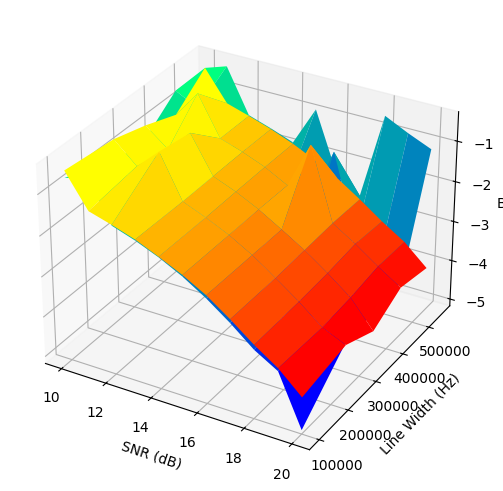

In [76]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(snrValues, lineWidth)

Z1 = BER[0, :, :]
Z2 = BER[1, :, :]

figure = plt.figure(figsize=(10, 5))
axesPlot = plt.axes(projection='3d')

axesPlot.plot_surface(X, Y, np.log10(Z1), cmap='winter')
axesPlot.plot_surface(X, Y, np.log10(Z2), cmap='autumn')

axesPlot.set_xlabel('SNR (dB)')
axesPlot.set_ylabel('Line Width (Hz)')
axesPlot.set_zlabel('BER')
#axesPlot.set_title(f'BER 3D')

plt.tight_layout()